In [2]:
import cdsapi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import os


In [23]:
def get_imagery(event_TIP, variable="2m_temperature"):
    """Fetch temperature data two weeks before & after an event, handling month transitions."""
    
    # Convert event_TIP (string) to datetime
    event_date = datetime.strptime(event_TIP.DECAY_EPOCH, "%Y-%m-%d %H:%M:%S")
    
    # Compute start & end dates
    start_date = event_date - timedelta(days=4)
    end_date = event_date + timedelta(days=4)

    # Extract relevant years & months
    start_year, start_month = start_date.year, start_date.month
    end_year, end_month = end_date.year, end_date.month

    # Define area (N, W, S, E)
    lat = event_TIP.LAT
    lon = event_TIP.LON - 360 if event_TIP.LON > 180 else event_TIP.LON

    lat_range = [lat + 20, lat - 20]
    lon_range = [lon - 20, lon + 20]

    # Function to request data for a specific month
    def request_data(year, month, days, filename):
        dataset = "reanalysis-era5-single-levels"
        request = {
            "product_type": ["reanalysis"],
            "variable": [variable],
            "year": str(year),
            "month": str(month).zfill(2),
            "day": [str(d).zfill(2) for d in days],  # Ensure days are properly formatted
            "time": [f"{str(h).zfill(2)}:00" for h in range(24)],  # All 24 hours
            "data_format": "netcdf",
            "area": [lat_range[0], lon_range[0], lat_range[1], lon_range[1]],  # N, W, S, E
        }
        c = cdsapi.Client()
        c.retrieve(dataset, request, filename)

    # create directory
    os.mkdir(f"data/sat_imagery/{event_TIP.NORAD_CAT_ID}")

    # Separate requests if the event period crosses into a new month
    if start_year == end_year and start_month == end_month:
        # Single request if within the same month
        days = list(range(start_date.day, end_date.day + 1))
        request_data(start_year, start_month, days, f"data/sat_imagery/{event_TIP.NORAD_CAT_ID}/{variable}_data.nc")
    else:
        # Request first month's data
        start_month_days = list(range(start_date.day, 32))  # 32 ensures end of month
        request_data(start_year, start_month, start_month_days, f"data/sat_imagery/{event_TIP.NORAD_CAT_ID}/{variable}_data_part1.nc")

        # Request second month's data
        end_month_days = list(range(1, end_date.day + 1))
        request_data(end_year, end_month, end_month_days, f"data/sat_imagery/{event_TIP.NORAD_CAT_ID}/{variable}_data_part2.nc")

    print("Data retrieval complete!")


def load_imagery(event_TIP):
    ds_arr = []
    for file in os.listdir(f"data/sat_imagery/{event_TIP.NORAD_CAT_ID}"):
        ds_arr.append(xr.open_dataset(f"data/sat_imagery/{event_TIP.NORAD_CAT_ID}/{file}"))
    return xr.concat(ds_arr, dim="valid_time")
            

In [33]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


def analyze_imagery(input_ds, analysis_type, event_TIP):
    """
    Analyze the temperature data in the given dataset.

    Parameters:
    - input_ds: xarray.Dataset
        Input dataset containing temperature data with a time dimension labeled as 'valid_time'.
    - analysis_type: str
        Type of analysis to be performed. Options are "std_dev", "iqr", and "mean".

    Returns:
    - result_diff: xarray.DataArray
        The difference in analysis metric (standard deviation, IQR, or mean) before and after a certain event date.

    Note:
    - Temperature in the dataset is assumed to be in Kelvin and is converted to Celsius.
    """
    # Convert event_TIP (string) to datetime
    event_date = datetime.strptime(event_TIP.DECAY_EPOCH, "%Y-%m-%d %H:%M:%S")
    
    # Compute start & end dates
    start_date = event_date - timedelta(days=4)
    end_date = event_date + timedelta(days=4)

    # Convert Kelvin to Celsius
    input_ds["t2m"] = input_ds["t2m"] - 273.15

    # Split into before and after datasets
    before_event = input_ds.sel(valid_time=slice(start_date, event_date))
    after_event = input_ds.sel(valid_time=slice(event_date, end_date))

    if analysis_type == "std_dev":
        # Compute standard deviation
        before_metric = before_event["t2m"].std(dim="valid_time")
        after_metric = after_event["t2m"].std(dim="valid_time")
    elif analysis_type == "iqr":
        # Compute interquartile range
        before_q1 = before_event["t2m"].quantile(0.25, dim="valid_time")
        before_q3 = before_event["t2m"].quantile(0.75, dim="valid_time")
        after_q1 = after_event["t2m"].quantile(0.25, dim="valid_time")
        after_q3 = after_event["t2m"].quantile(0.75, dim="valid_time")
        before_metric = before_q3 - before_q1
        after_metric = after_q3 - after_q1
    elif analysis_type == "mean":
        # Compute mean
        before_metric = before_event["t2m"].mean(dim="valid_time")
        after_metric = after_event["t2m"].mean(dim="valid_time")
    else:
        raise ValueError("Unsupported analysis type")

    # Compute the difference
    result_diff = after_metric - before_metric

    return result_diff

def show_imagery(imagery, event_TIP, title):
    # Set up the map projection (PlateCarree is best for lat/lon data)
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

    # Plot the data (std dev, IQR, mean difference, etc.)
    imagery.plot(
        ax=ax,
        cmap="coolwarm",
        transform=ccrs.PlateCarree(),
        cbar_kwargs={"label": "Temperature Difference (°C)"},  # Adjust label as needed
    )

    # Add map features
    ax.coastlines()  
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black")
    ax.add_feature(cfeature.LAKES, edgecolor="black")
    ax.add_feature(cfeature.RIVERS, linestyle="--")

    # Add marker for reentry site (use LAT, LON from event_TIP)
    ax.plot(
        event_TIP.LON, 
        event_TIP.LAT, 
        'ro', 
        markersize=8, 
        transform=ccrs.Geodetic(),
        label="Decay Site"
    )

    # Optionally set the map extent (longitude min, longitude max, latitude min, latitude max)
    # to be sure the marker is in view:
    ax.set_extent([
        event_TIP.LON - 32, 
        event_TIP.LON + 32, 
        event_TIP.LAT - 18, 
        event_TIP.LAT + 18
    ], crs=ccrs.PlateCarree())

    # Set labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{title} for NORAD {event_TIP.NORAD_CAT_ID} reentry on {event_TIP.DECAY_EPOCH}")
    plt.legend()
    plt.show()

In [30]:
import pandas as pd

# Add each JSONs data to dataframe
df = pd.DataFrame()
for file in os.listdir("data/TIPs"):
    df = pd.concat([df, pd.read_json("data/TIPs/"+file)])

df = df.sort_values(by=['OBJECT_NUMBER', 'WINDOW'], ascending=False)

# Group by 'OBJECT_NUMBER' and take the last entry for each group
last_tips = df.groupby('OBJECT_NUMBER').tail(1).reset_index(drop=True)

last_tips = last_tips[last_tips["WINDOW"] == 1]
last_tips


,NORAD_CAT_ID,MSG_EPOCH,INSERT_EPOCH,DECAY_EPOCH,WINDOW,REV,DIRECTION,LAT,LON,INCL,NEXT_REPORT,ID,HIGH_INTEREST,OBJECT_NUMBER
0,62408,2024-12-29 23:10:00,2024-12-29 23:18:34,2024-12-29 21:35:00,1,133,descending,-39.5,70.7,97.5,0,37424,N,62408
1,62191,2024-12-05 22:28:00,2024-12-05 22:46:34,2024-12-05 16:19:00,1,16,ascending,7.5,147.1,46.1,0,36909,N,62191
2,62113,2024-12-24 15:58:00,2024-12-24 16:28:36,2024-12-24 10:50:00,1,431,descending,42.5,147.9,49.9,0,37267,N,62113
3,62087,2024-12-07 22:36:00,2024-12-07 22:46:32,2024-12-07 20:49:00,1,200,descending,39.9,301.0,97.9,0,36929,N,62087
4,62031,2024-11-23 17:22:00,2024-11-23 17:38:37,2024-11-23 11:58:00,1,32,descending,-18.4,161.8,51.6,0,36796,N,62031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,5117,2023-11-03 06:12:00,2023-11-03 06:36:50,2023-11-03 03:27:00,1,87152,descending,28.0,174.0,81.2,0,21813,N,5117
2475,4814,2024-04-06 06:03:00,2024-04-06 06:16:29,2024-04-06 03:51:00,1,91721,ascending,-75.0,330.6,81.1,0,22843,N,4814
2477,4394,2024-10-25 21:40:00,2024-10-25 21:56:20,2024-10-25 13:52:00,1,97785,descending,72.3,327.8,81.2,0,35587,N,4394
2479,3835,2012-03-26 21:46:00,2012-03-26 17:26:55,2012-03-26 21:22:00,1,35517,ascending,47.0,95.0,81.1,0,3018,N,3835


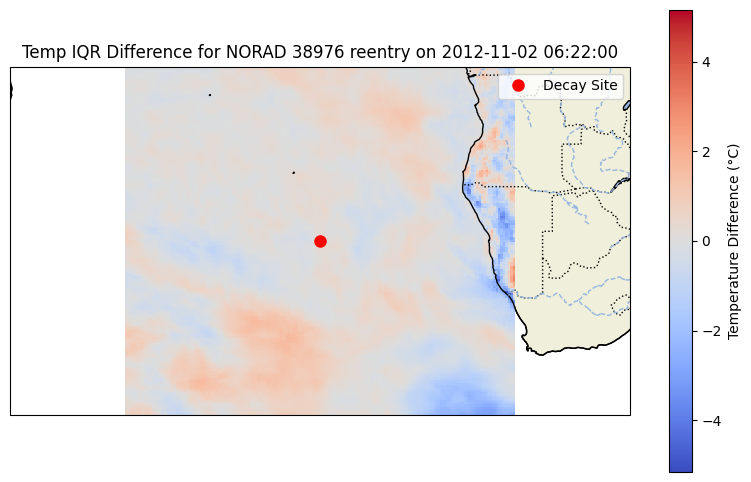

IndexError: single positional indexer is out-of-bounds

In [36]:
for dir in os.listdir("data/sat_imagery"):
    reentry = last_tips[last_tips["NORAD_CAT_ID"] == int(dir)].iloc[0]

    ds = load_imagery(reentry)
    analysis = analyze_imagery(ds, "iqr", reentry)
    show_imagery(analysis, reentry, "Temp IQR Difference")


In [ ]:
# sample a random group of reentries

for i, reentry in last_tips.sample(5).iterrows():
    variable = "2m_temperature"
    get_imagery(reentry, variable)

    ds = load_imagery(reentry)
    analysis = analyze_imagery(ds, "iqr", reentry)
    show_imagery(analysis, reentry, "Temp IQR Difference")


2025-02-27 16:52:35,465 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-27 16:52:35,466 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-27 16:52:36,522 INFO Request ID is dd8ba614-4760-43d9-8dd6-145b6c75f6bd
2025-02-27 16:52:36,789 INFO status has been updated to accepted


KeyboardInterrupt: 